# Make Dataset

- sample positve class
- sample negative class
- refine negative

In [75]:
# Autorelaod
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
import igraph as ig
import leidenalg
from scipy.special import softmax
import re
from statsmodels.stats.multitest import multipletests

os.chdir("/home/gdallagl/myworkdir/ESMSec")
print(f"Working directory successfully changed to: {os.getcwd()}")

import utils.my_functions as mf
import utils.dataset_functions as dataf

config_file="/home/gdallagl/myworkdir/ESMSec/config/config.yaml"
config = mf.load_config(config_file)

mf.set_all_seeds(config["random_seed"])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Working directory successfully changed to: /home/gdallagl/myworkdir/ESMSec
Seeds set successfully to 42 for random, numpy, and PyTorch (if used).


# Load definitive positive genes

In [76]:
positive_genes_df = pd.read_csv(config["data_paths"]["final_positive_genes"])
#positive_genes_df = pd.read_csv("/home/gdallagl/myworkdir/ESMSec/data/secreted/positive_lyso_proteins.csv")

display(positive_genes_df)
positive_genes = set(positive_genes_df[positive_genes_df.definitive_positive == True].gene)
ambiguos_genes = set(positive_genes_df[positive_genes_df.definitive_positive == False].gene)
print("Number positive genes", len(positive_genes))
print("Number ambiguos genes", len(ambiguos_genes))

,gene,geneset_count,is_guaranteed,geneset_count_all,label,geneset_percent,p_by_visual,p_by_wilcoxon,p_by_broad,n_positive,definitive_positive
0,OIP5,11,True,199,positive,3.780069,True,True,True,2,True
1,SASS6,28,False,274,positive,9.621993,True,True,True,2,True
2,DEPDC1B,8,False,189,positive,2.749141,True,True,True,2,True
3,MAD2L2,28,False,545,positive,9.621993,True,True,True,2,True
4,CKS2,28,True,451,positive,9.621993,True,True,True,2,True
...,...,...,...,...,...,...,...,...,...,...,...
7289,CUX1,2,False,452,ambigous,0.687285,False,False,False,0,False
7290,CUX2,2,False,257,ambigous,0.687285,False,False,False,0,False
7291,CWC15,2,False,121,ambigous,0.687285,False,False,False,0,False
7292,CWC27,2,False,299,ambigous,0.687285,False,False,False,0,False


Number positive genes 202
Number ambiguos genes 7092


In [77]:
# Create mapping positive_gene --> number genesets

# make postive gene-freq mapping
    # Filter ONLY positive genes
tmp = positive_genes_df[positive_genes_df["definitive_positive"] == True]

# Create a mapping: gene -> frequency
positive_gene_freq_map = dict(zip(tmp["gene"], tmp["geneset_count"]))
positive_gene_freq_map

{'OIP5': 11,
 'SASS6': 28,
 'DEPDC1B': 8,
 'MAD2L2': 28,
 'CKS2': 28,
 'CDKN2C': 28,
 'TOP2A': 28,
 'CCNF': 27,
 'LMNA': 11,
 'DBF4B': 27,
 'CEP70': 11,
 'CEP72': 11,
 'CDKN3': 27,
 'UBE2S': 32,
 'YWHAH': 10,
 'BRD8': 8,
 'KIF20A': 27,
 'G2E3': 8,
 'HMMR': 16,
 'CKAP5': 26,
 'CKS1B': 26,
 'CDCA3': 10,
 'RCC1': 26,
 'CCSAP': 19,
 'MAPRE1': 26,
 'POC1A': 19,
 'PLK4': 19,
 'MIIP': 19,
 'CNTRL': 11,
 'STIL': 32,
 'SMC4': 32,
 'SPC24': 32,
 'CENPT': 11,
 'FANCI': 9,
 'KIF14': 32,
 'FAM110A': 11,
 'DBF4': 31,
 'KIF2C': 31,
 'PTTG1': 31,
 'SMC2': 31,
 'RACGAP1': 31,
 'TMPO': 15,
 'JADE1': 21,
 'CDKN2D': 30,
 'HJURP': 18,
 'MKI67': 30,
 'PRC1': 30,
 'PBK': 14,
 'CENPO': 11,
 'BANF1': 11,
 'PPP2R5C': 9,
 'KIF11': 29,
 'CALM2': 11,
 'BTG3': 11,
 'RANGRF': 11,
 'CKAP2': 18,
 'CENPA': 29,
 'ANLN': 30,
 'TUBB6': 12,
 'RHNO1': 23,
 'KIF18B': 15,
 'NCAPG': 20,
 'SPAG5': 23,
 'RAN': 15,
 'NDE1': 22,
 'DEPDC1': 10,
 'LMNB1': 15,
 'HMGN2': 9,
 'CCNH': 22,
 'CENPL': 15,
 'CENPM': 22,
 'KNSTRN': 19,
 'KIF

# Define set of allowed proteins for the analyss

Focus only on:
- human
- reviwed
- no isoforms

In [78]:
proteome_uniprot = pd.read_csv(config["data_paths"]["human_proteome_uniprot"], sep="\t")

# ONLY Human 
    # csv file alredy fitered by species

# ONLY swissprot
if config["dataset_creation"]["use_only_reviewed_proteins"]:
    proteome_uniprot_reviewed = proteome_uniprot[proteome_uniprot.Reviewed == "reviewed"].copy()
    print("reviewed shape: ", proteome_uniprot_reviewed.shape)

# No isofrom, use canonical protein
proteome_uniprot_reviewed['IsIsoform'] = proteome_uniprot_reviewed['Entry'].str.contains(r'-\d+$')
n_isoforms = proteome_uniprot_reviewed['IsIsoform'].sum()
n_total = len(proteome_uniprot_reviewed)
print(f"Isoforms: {n_isoforms} / {n_total} ({n_isoforms/n_total:.2%})")

# Define proteins to use in the follwing analasys
allowed_proteins = set(proteome_uniprot_reviewed.Entry)
print("Number allowed proteins: ", len(allowed_proteins))
print(*list(allowed_proteins)[:10], "...")

reviewed shape:  (20405, 7)
Isoforms: 0 / 20405 (0.00%)
Number allowed proteins:  20405
Q08462 Q8N3P4 Q6NUI1 Q14240 Q96NI8 P15121 Q9Y462 Q15723 P14616 Q03923 ...


In [79]:
# # ATTENTION: same protein can have mutliple genes
# print("Gens mapping to Q9P1J3 -->", proteome_uniprot[proteome_uniprot["Entry"] == "Q9P1J3"]["Gene Names"].values)

# # ATTENTION: soem proteins can have Nan geens
# display(proteome_uniprot[proteome_uniprot["Entry"] == "Q9N2K0"])

# # ATTNETION: are there ducplatd proteins
# print("number duplicated proteins:", proteome_uniprot_reviewed.Entry.duplicated().sum())


# Create Protein -  Gene - Uniref50 Mapping

In [80]:
# Read uniport ID mapping
uniprot_id_mapping_df = pd.read_csv(config["data_paths"]["uniprot_mapping_id"], sep='\t', header=None, names=['UniProtKB_Accession', 'ID_Type', 'External_ID'])
#print(uniprot_id_mapping_df.ID_Type.unique())
uniprot_id_mapping_df.head(2)

,UniProtKB_Accession,ID_Type,External_ID
0,P31946,UniProtKB-ID,1433B_HUMAN
1,P31946,Gene_Name,YWHAB


In [81]:
# select protein and gene IDs
protein2uniref = uniprot_id_mapping_df[uniprot_id_mapping_df.ID_Type == "UniRef50"].copy()
gene2protein = uniprot_id_mapping_df[uniprot_id_mapping_df.ID_Type == "Gene_Name"].copy()

# filter only allowed proteins
protein2uniref = protein2uniref[protein2uniref.UniProtKB_Accession.isin(allowed_proteins)]
gene2protein = gene2protein[gene2protein.UniProtKB_Accession.isin(allowed_proteins)]

# raname
protein2uniref = (
    protein2uniref
    .rename(columns={"UniProtKB_Accession": "protein", "External_ID": "UniRef50_Cluster"})
    .drop(columns=["ID_Type"])
)
gene2protein = (
    gene2protein
    .rename(columns={"UniProtKB_Accession": "protein", "External_ID": "gene"})
    .drop(columns=["ID_Type"])
)
display(protein2uniref)
display(gene2protein)

,protein,UniRef50_Cluster
13,P31946,UniRef50_P31946
131,P62258,UniRef50_P62258
273,Q04917,UniRef50_Q04917
377,P61981,UniRef50_P61981
541,P31947,UniRef50_P31947
...,...,...
1868137,Q6WRX3,UniRef50_Q6WRX3
1868192,Q9C0D3,UniRef50_Q9C0D3
1868268,Q15942,UniRef50_Q15942
1868355,O43149,UniRef50_O43149


,protein,gene
1,P31946,YWHAB
120,P62258,YWHAE
251,Q04917,YWHAH
342,P61981,YWHAG
470,P31947,SFN
...,...,...
1868129,Q6WRX3,ZYG11A
1868183,Q9C0D3,ZYG11B
1868246,Q15942,ZYX
1868344,O43149,ZZEF1


In [82]:
# Create gene-protein mapping

# Add gene name to protein
uniref_df = pd.merge(how="inner", left=gene2protein, right=protein2uniref, on="protein")

# ATTENTION
    # protein --> mapped to multiple genes 
        # (ex. special gene mutation, but same protein name)
    # gene --> mapped to multiple protein
        # (ex. isofoms) --> took care before (allowed_gene filtering)
        # (ex. differt proteins)
print("number duplciated proteins: ", uniref_df.protein.duplicated().sum()) # no protesin mapped to multiple genes
print("number duplciated genes: ", uniref_df.gene.duplicated().sum())

duplicated_proteins = uniref_df[uniref_df["protein"].duplicated(keep=False)]
duplicated_genes = uniref_df[uniref_df["gene"].duplicated(keep=False)]

display(duplicated_genes)
display(duplicated_proteins)

number duplciated proteins:  127
number duplciated genes:  83


,protein,gene,UniRef50_Cluster
558,O43687,AKAP7,UniRef50_O43687
559,Q9P0M2,AKAP7,UniRef50_Q6JP77
611,P84996,GNAS,UniRef50_Q6R0H6
896,C0HMD6,PIDD1,UniRef50_C0HMD6
932,F7VJQ1,PRNP,UniRef50_F7VJQ1
...,...,...,...
19243,P63131,ERVK-7,UniRef50_Q9Y6I0
19244,P63122,ERVK-8,UniRef50_P10265
19245,P63127,ERVK-9,UniRef50_P63128
19932,Q70YC5,ZNF365,UniRef50_Q70YC5


,protein,gene,UniRef50_Cluster
1044,Q8IVW1,ARL17A,UniRef50_Q8IVW1
1045,Q8IVW1,ARL17B,UniRef50_Q8IVW1
1676,Q9H3K6,BOLA2,UniRef50_Q9H3K6
1677,Q9H3K6,BOLA2B,UniRef50_Q9H3K6
2284,Q8NHW4,CCL4L1,UniRef50_P10147
...,...,...,...
19153,O14599,BPY2,UniRef50_O14599
19154,O14599,BPY2B,UniRef50_O14599
19155,O14599,BPY2C,UniRef50_O14599
19467,Q9HD64,XAGE1A,UniRef50_Q9HD64


In [83]:
# REMOVE PORTEIN DUPLICATES

# Subset protein with mutliple gene to have only one gene
    # take it randomly
    # BUT sample before a gene from "postiev_gene" if rpesent

# add a helper column to mark whether the gene is "positive"
uniref_df["is_positive"] = uniref_df["gene"].isin(positive_genes)

# sort so that positive ones come first for each protein
uniref_df = uniref_df.sort_values(["protein", "is_positive"], ascending=[True, False])

# drop duplicates, keeping the first (which will be the positive one if it exists)
    # ATTENTION: if there are multiple postive genes, you will lose some !!!
uniref_df = uniref_df.drop_duplicates(subset="protein", keep="first")

# drop the helper column if no longer needed
uniref_df = uniref_df.drop(columns=["is_positive"])

In [84]:
# REMOVE GENES DUPLICATED

# Subset genes with mutliple protein to have only one protein
    # take it randomly
    # BUT sample before a gene from "postiev_gene" if rpesent
uniref_df["is_positive"] = uniref_df["gene"].isin(positive_genes)
uniref_df = uniref_df.sort_values(["gene", "is_positive"], ascending=[True, False])
uniref_df = uniref_df.drop_duplicates(subset="gene", keep="first")
uniref_df = uniref_df.drop(columns=["is_positive"])

In [85]:
# final check
print("number duplciated proteins: ", uniref_df.protein.duplicated().sum()) # no protesin mapped to multiple genes
print("number duplciated genes: ", uniref_df.gene.duplicated().sum())
uniref_df

number duplciated proteins:  0
number duplciated genes:  0


,protein,gene,UniRef50_Cluster
72,P04217,A1BG,UniRef50_P04217
73,Q9NQ94,A1CF,UniRef50_Q9NQ94
83,P01023,A2M,UniRef50_P01023
84,A8K2U0,A2ML1,UniRef50_A8K2U0
86,U3KPV4,A3GALT2,UniRef50_U3KPV4
...,...,...,...
20389,Q6WRX3,ZYG11A,UniRef50_Q6WRX3
20390,Q9C0D3,ZYG11B,UniRef50_Q9C0D3
20391,Q15942,ZYX,UniRef50_Q15942
20392,O43149,ZZEF1,UniRef50_O43149


# Create Uniref50 Clusters

,UniRef50_Cluster,protein,gene,n_proteins,n_genes
11076,UniRef50_Q86YD7,"[Q86YD7, A6NDY2, A0A8V8TNH8, A8MX19, P0C7W8, P...","[FAM90A1, FAM90A10, FAM90A11, FAM90A12, FAM90A...",22,22
9864,UniRef50_Q6R6M4,"[Q7RTZ2, C9JJH3, C9JVI0, C9JPN9, C9JLJ4, C9J2P...","[USP17L1, USP17L10, USP17L11, USP17L12, USP17L...",19,19
7023,UniRef50_Q13066,"[P0DTW1, A6NGK3, A1L429, P0CL80, P0CL81, A6NDE...","[GAGE1, GAGE10, GAGE12B, GAGE12F, GAGE12G, GAG...",17,17
18731,UniRef50_Q9Y5E9,"[Q9UN67, Q9Y5F2, Q9Y5F1, Q9Y5F0, Q9Y5E9, Q9Y5E...","[PCDHB10, PCDHB11, PCDHB12, PCDHB13, PCDHB14, ...",13,13
9125,UniRef50_Q5VXH4,"[O60813, O95522, P0DUQ1, Q5VT98, A6NGN4, H0Y7S...","[PRAMEF11, PRAMEF12, PRAMEF15, PRAMEF20, PRAME...",13,13
...,...,...,...,...,...
6525,UniRef50_Q01726,[Q01726],[MC1R],1,1
6524,UniRef50_Q01718,[Q01718],[MC2R],1,1
6523,UniRef50_Q01705,[P46531],[NOTCH1],1,1
6522,UniRef50_Q01668,[Q01668],[CACNA1D],1,1


<Axes: xlabel='n_proteins', ylabel='Number of Cluster with ...'>

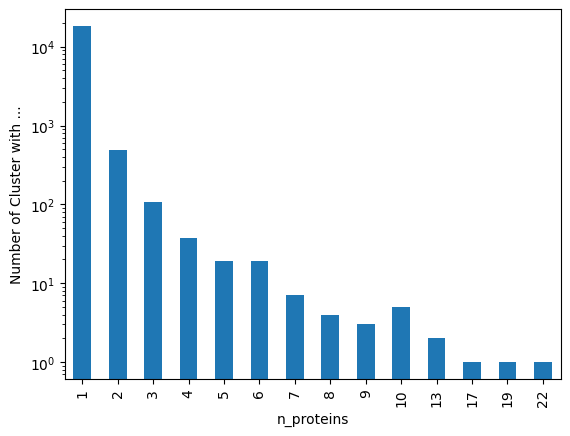

In [86]:
# create a df with clusters as entry
uniref_df = uniref_df.groupby('UniRef50_Cluster').agg({
    'protein': list,
    'gene': list,
}).reset_index()

# count
uniref_df["n_proteins"] = uniref_df.protein.apply(len)
uniref_df["n_genes"] = uniref_df.gene.apply(len)
uniref_df.sort_values(by="n_proteins", inplace=True, ascending=False)

# plot
display(uniref_df)
uniref_df.n_proteins.value_counts().sort_index().plot(kind="bar", logy=True, ylabel="Number of Cluster with ...")

In [87]:
# CHECK: genes or proteins shared acorss clusters

# explode the lists into one row per (cluster, protein)
protein_cluster_map = uniref_df.explode("protein")[["UniRef50_Cluster", "protein"]].dropna()
gene_cluster_map = uniref_df.explode("gene")[["UniRef50_Cluster", "gene"]].dropna()

# group by protein and collect all clusters that contain it
protein_to_clusters = protein_cluster_map.groupby("protein")["UniRef50_Cluster"].unique()
gene_to_clusters = gene_cluster_map.groupby("gene")["UniRef50_Cluster"].unique()

# keep only proteins that occur in >1 cluster
shared_proteins = protein_to_clusters[protein_to_clusters.apply(len) > 1]
shared_genes = gene_to_clusters[gene_to_clusters.apply(len) > 1]

print(f"{len(shared_proteins)} proteins are shared between clusters")
#display(shared_proteins.head())
print(f"{len(shared_genes)} genes are shared between clusters")
#display(shared_genes.head())


0 proteins are shared between clusters
0 genes are shared between clusters


## Mark positive genes and clusters

cluster_label
negative    18791
positive      196
Name: count, dtype: int64


,UniRef50_Cluster,protein,gene,n_proteins,n_genes,cluster_label,proteins_positive,genes_positive,n_genes_positive
3447,UniRef50_P0DP23,"[P0DP23, P0DP24, P0DP25]","[CALM1, CALM2, CALM3]",3,3,positive,"[P0DP23, P0DP24, P0DP25]","[CALM1, CALM2, CALM3]",3
7124,UniRef50_Q13362,[Q13362],[PPP2R5C],1,1,positive,[Q13362],[PPP2R5C],1
18151,UniRef50_Q9ULW0,[Q9ULW0],[TPX2],1,1,positive,[Q9ULW0],[TPX2],1
17796,UniRef50_Q9UH99,[Q9UH99],[SUN2],1,1,positive,[Q9UH99],[SUN2],1
6238,UniRef50_P68371,[P68371],[TUBB4B],1,1,positive,[P68371],[TUBB4B],1


(18987, 9)

<Axes: xlabel='n_genes_positive'>

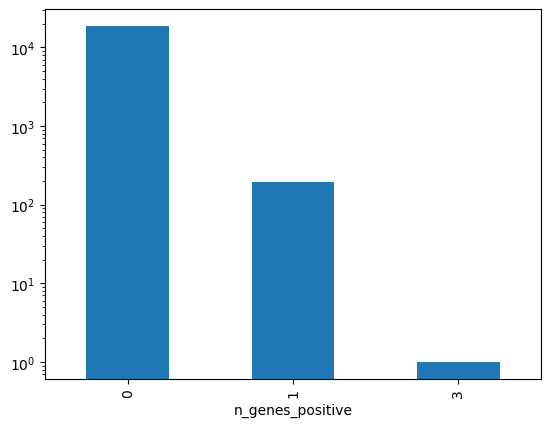

In [88]:
# Add the 'label' column: 'positive' if at least one protein maps to a positive gene, otherwise 'negative'
uniref_df["cluster_label"] = uniref_df["gene"].apply(
    lambda gene_list: "positive" 
    if any(g in positive_genes for g in gene_list)
    else "negative"
)

# plot how many postive genesets
print(uniref_df["cluster_label"].value_counts())#.sort_index().plot(kind="bar", logy=True,)

#########

# create list of genes AND CORREPSONDET prots that are postive (from above)

# unzip in parallel pritens_clened and genes_clened and create ritens_clened_psotive and genes_clened_positive 
    # maintain if proteins comes form psotive gene
uniref_df["proteins_positive"], uniref_df["genes_positive"] = zip(*uniref_df.apply(
    lambda row: (
        [p for p, g in zip(row["protein"], row["gene"]) if g in positive_genes],
        [g for g in row["gene"] if g in positive_genes]
    ),
    axis=1
))
uniref_df["n_genes_positive"] = uniref_df["genes_positive"].apply(len)
uniref_df.sort_values(by="n_genes_positive", ascending=False, inplace=True)

display(uniref_df.head(5))
display(uniref_df.shape)
uniref_df.n_genes_positive.value_counts().plot(kind="bar", logy=True)

## Give probs to positive genes

In [89]:
# give probablities to be samped to each protein
uniref_df["logits"] = uniref_df["genes_positive"].apply(
    lambda gene_list: [positive_gene_freq_map.get(g, 0) for g in gene_list]
)
def safe_softmax(logits):
    if len(logits) == 0:
        return []  # return empty list if no logits
    return softmax(logits).tolist()  # convert numpy array to list
uniref_df["probs"] = uniref_df["logits"].apply(safe_softmax)

uniref_df.head(2)

,UniRef50_Cluster,protein,gene,n_proteins,n_genes,cluster_label,proteins_positive,genes_positive,n_genes_positive,logits,probs
3447,UniRef50_P0DP23,"[P0DP23, P0DP24, P0DP25]","[CALM1, CALM2, CALM3]",3,3,positive,"[P0DP23, P0DP24, P0DP25]","[CALM1, CALM2, CALM3]",3,"[9, 11, 9]","[0.10650697891920073, 0.7869860421615984, 0.10..."
7124,UniRef50_Q13362,[Q13362],[PPP2R5C],1,1,positive,[Q13362],[PPP2R5C],1,[9],[1.0]


## Create lists of NEGATIVE genes within i can sample

Negative genes are too many.

We need a subsampling before sample them for the final df.
We need to subsample in differt ways:

- lets have nice lenghts: too long, too short
- they cant be positive genes
- they cant be ambiguos genes
- many proteins of same class but still differt (ex. odoranr receptros)
    - SOLUTION: solve wht pfam and interpro domains --> group proteins that have same domains --> take only one from the group


Other ideas if necessary:
- cluster proteins using uniT5 embs and take a protien for each cluster
- proteins still 90% similairty, need to remove reduntat seqeunces?
    - --> impossible, clusters are dissimailr by 50%

### *) Read Domains df

In [90]:
interpro_df = pd.read_csv(config["data_paths"]["interprot_domains"], sep="\t")

def extract_ids(cell, prefix):
    if pd.isna(cell):
        return []
    # Find all matches like PFxxxxx or IPRxxxxx
    ids = re.findall(rf"{prefix}\d+", cell)
    return list(set(ids))  # optional: remove duplicates

# Apply parsing
interpro_df["Pfam_list"] = interpro_df["Pfam"].apply(lambda x: extract_ids(str(x), "PF"))
interpro_df["InterPro_list"] = interpro_df["InterPro"].apply(lambda x: extract_ids(str(x), "IPR"))

interpro_df["n_Pfam"] = interpro_df["Pfam_list"].apply(len)
interpro_df["n_InterPro"] = interpro_df["InterPro_list"].apply(len)

interpro_df["all_domains"] = interpro_df.apply(lambda row: set(row['Pfam_list']) | set(row['InterPro_list']), axis=1)

interpro_df

,Entry,Length,Pfam,InterPro,Pfam_list,InterPro_list,n_Pfam,n_InterPro,all_domains
0,A0A087X1C5,515,PF00067; p450; 2.;,"IPR001128; Cyt_P450.;""IPR017972; Cyt_P450_CS.""...",[PF00067],"[IPR036396, IPR002401, IPR008069, IPR001128, I...",1,6,"{IPR017972, IPR036396, PF00067, IPR002401, IPR..."
1,A0A0B4J2F0,54,PF23670; PIGBOS1; 1.;,NaN,[PF23670],[],1,0,{PF23670}
2,A0A0C5B5G6,16,PF21945; MT-RNR1; 1.;,IPR054130; MT-RNR1.;,[PF21945],[IPR054130],1,1,"{IPR054130, PF21945}"
3,A0A0K2S4Q6,201,PF07686; V-set; 1.;,"IPR050671; CD300_family_receptors.;""IPR007110;...",[PF07686],"[IPR050671, IPR036179, IPR013783, IPR003599, I...",1,6,"{IPR003599, PF07686, IPR013106, IPR050671, IPR..."
4,A0A0U1RRE5,68,PF21949; NoBody; 1.;,IPR047852; NoBody.;,[PF21949],[IPR047852],1,1,"{PF21949, IPR047852}"
...,...,...,...,...,...,...,...,...,...
20415,Q9UI25,63,NaN,NaN,[],[],0,0,{}
20416,Q9UI54,55,NaN,NaN,[],[],0,0,{}
20417,Q9UI72,69,NaN,NaN,[],[],0,0,{}
20418,Q9Y3F1,56,PF15789; Hyr1; 1.;,IPR031573; Cell_wall_rpt.;,[PF15789],[IPR031573],1,1,"{IPR031573, PF15789}"


### *) Create df gene-prot to define negative prots

Attch col to say if the protsin is ok based on taht criterion

In [91]:
# Create lists to store protein-gene pairs
proteins_list = []
genes_list = []

# Iterate through each row and expand the lists
for _, row in uniref_df.iterrows():
    proteins = row['protein']
    genes = row['gene']
    
    # Add each protein-gene pair
    for protein, gene in zip(proteins, genes):
        proteins_list.append(protein)
        genes_list.append(gene)

# Create new dataframe with unique pairs
putative_negative_protein_gene_df = pd.DataFrame({
    'protein': proteins_list,
    'gene': genes_list
})#.drop_duplicates() # no duplicates thnaks tot he previous steps

putative_negative_protein_gene_df = pd.merge(how="left", left=putative_negative_protein_gene_df, right=interpro_df[["Entry", "Length"]], left_on="protein", right_on="Entry").drop(columns=["Entry"])

display(putative_negative_protein_gene_df)

,protein,gene,Length
0,P0DP23,CALM1,149
1,P0DP24,CALM2,149
2,P0DP25,CALM3,149
3,Q13362,PPP2R5C,524
4,Q9ULW0,TPX2,747
...,...,...,...
20179,Q9Y483,MTF2,593
20180,Q9Y484,WDR45,360
20181,Q9Y3R4,NEU2,380
20182,Q9Y3P8,SIT1,196


### Filter by Length

In [92]:
putative_negative_protein_gene_df = putative_negative_protein_gene_df[
    (putative_negative_protein_gene_df.Length >= config["dataset_creation"]["min_length_negative_protein"]) &
    (putative_negative_protein_gene_df.Length <= config["dataset_creation"]["max_length_negative_protein"]) 
]
putative_negative_protein_gene_df

,protein,gene,Length
0,P0DP23,CALM1,149
1,P0DP24,CALM2,149
2,P0DP25,CALM3,149
3,Q13362,PPP2R5C,524
4,Q9ULW0,TPX2,747
...,...,...,...
20179,Q9Y483,MTF2,593
20180,Q9Y484,WDR45,360
20181,Q9Y3R4,NEU2,380
20182,Q9Y3P8,SIT1,196


### Filter by Positive/Ambiguos

In [93]:
putative_negative_protein_gene_df = putative_negative_protein_gene_df[
    (~ putative_negative_protein_gene_df.gene.isin(ambiguos_genes)) &
    (~ putative_negative_protein_gene_df.gene.isin(positive_genes)) 
]
putative_negative_protein_gene_df

,protein,gene,Length
202,A0PJZ0,ANKRD20A5P,165
203,A0M8Q6,IGLC7,106
207,A0FGR9,ESYT3,886
210,A0A1B0GUA6,CCDC195,201
211,A0PJK1,SLC5A10,596
...,...,...,...
20176,Q9Y471,CMAHP,501
20178,Q9Y478,PRKAB1,270
20180,Q9Y484,WDR45,360
20181,Q9Y3R4,NEU2,380


### Remove duplicated protein domains

In [94]:
# Filter to current subset of prots
interpro_df = interpro_df[interpro_df.Entry.isin(putative_negative_protein_gene_df.protein.to_list())]

# Convert sets to frozensets for grouping (sets aren't hashable)
interpro_df['domains_hashable'] = interpro_df['all_domains'].apply(frozenset)

# Group by domains and aggregate
final_groups_df = (
    interpro_df[interpro_df.duplicated(subset=['domains_hashable'], keep=False)] #keep=False, mark all pccurencies
    .groupby('domains_hashable')['Entry']  # group by set of domains
    .agg(Proteins_in_Group=list, Group_Size='size')
        #Collect all the protein_id values in the group into a list
        #'size'	Count how many items are in the group
    .reset_index()
    .sort_values('Group_Size', ascending=False)
)

# Convert frozensets back to sets for display
final_groups_df['all_domains'] = final_groups_df['domains_hashable'].apply(set)
final_groups_df = final_groups_df.drop(columns=['domains_hashable'])

display(final_groups_df)

# Clean up the temporary column
interpro_df = interpro_df.drop(columns=['domains_hashable'])
interpro_df = interpro_df.drop_duplicates(subset="all_domains")

# Filter df
putative_negative_protein_gene_df = putative_negative_protein_gene_df[putative_negative_protein_gene_df.protein.isin(interpro_df.Entry.to_list())]

print("Remained proteins:", len(putative_negative_protein_gene_df))

/tmp/ipykernel_195943/2307221464.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interpro_df['domains_hashable'] = interpro_df['all_domains'].apply(frozenset)


,Proteins_in_Group,Group_Size,all_domains
0,"[P26371, P40205, P60329, Q2M2E3, Q5SWW7, Q66K8...",329,{}
1002,"[O43749, P34982, Q8NG98, Q8NHC4, Q96KK4, A4D2G...",245,"{IPR000725, PF13853, IPR017452, IPR000276}"
765,"[O94892, P17021, P52736, P52742, Q16587, Q3KNS...",90,"{PF01352, PF00096, IPR036236, IPR001909, IPR03..."
869,"[P01593, P01594, P01597, P01602, P01619, P0169...",65,"{IPR003599, PF07686, IPR013106, IPR050150, IPR..."
578,"[Q9H255, A6NGY5, Q8NGH7, Q8NGI2, Q8NGK2, Q8NH5...",58,"{PF13853, IPR017452, IPR000725, IPR000276, IPR..."
...,...,...,...
21,"[Q8NC01, Q9P126]",2,"{PF00059, IPR033992, IPR001304, IPR052309, IPR..."
20,"[Q8NBN3, Q96K49]",2,"{PF21901, IPR053937, IPR054101, IPR009637, PF0..."
19,"[Q8N3C7, Q96DZ5]",2,"{IPR000938, PF01302, PF12796, IPR036859, IPR03..."
1441,"[P31150, P50395]",2,"{IPR018203, IPR000806, PF00996, IPR036188}"


Remained proteins: 6730


# Optional: subsample to remove proteins with overlapping domains

In [95]:
# Convert domain sets to lists
domain_lists = interpro_df['all_domains'].apply(list)

# Create binary matrix: proteins x domains
mlb = MultiLabelBinarizer()
binary_matrix = mlb.fit_transform(domain_lists)

# Calculate Jaccard similarity
# Jaccard = intersection / union
X = binary_matrix.astype(float)
intersection = X @ X.T #intersection counts (like AND)
union = X.sum(axis=1).reshape(-1, 1) + X.sum(axis=1) - intersection #sum of each row pair minus their intersection
jaccard_matrix = intersection / union

# Convert to DataFrame
jaccard_df = pd.DataFrame(
    jaccard_matrix, 
    index=interpro_df['Entry'], 
    columns=interpro_df['Entry']
)

print(f"Shape: {binary_matrix.shape} (proteins x domains)")
print(f"\nJaccard similarity matrix:")
display(jaccard_df)

Shape: (6730, 15101) (proteins x domains)

Jaccard similarity matrix:


/tmp/ipykernel_195943/2586831039.py:13: RuntimeWarning: invalid value encountered in divide
  jaccard_matrix = intersection / union


Entry,A0A087X1C5,A0A0K2S4Q6,A0A1B0GTW7,A0AV02,A0AV96,A0AVF1,A0FGR9,A0JP26,A0M8Q6,A0PJK1,...,Q6UXQ4,Q6ZMV7,Q6ZR85,Q8N8J0,Q8WU49,Q8WZ69,Q96BT1,Q96KX1,Q96PS1,Q9H693
Entry,,,,,,,,,,,,,,,,,,,,,
A0A087X1C5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A0A0K2S4Q6,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.272727,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A0A1B0GTW7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A0AV02,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A0AV96,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q8WZ69,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Q96BT1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Q96KX1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Jaccard Similarity Statistics:
Min: 0.0189
Max: 0.9474
Mean: 0.2204
Median: 0.1579
Std: 0.1767


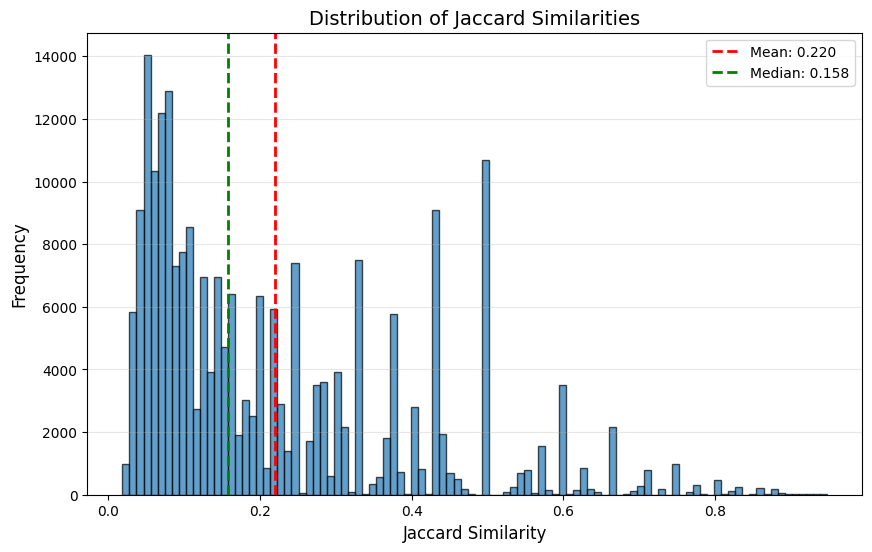

In [96]:
# Flatten the Jaccard matrix (exclude diagonal if it's 1.0 self-similarity)
jaccard_values = jaccard_matrix[np.triu_indices_from(jaccard_matrix, k=1)]  # Upper triangle only
jaccard_values = jaccard_values[jaccard_values != 0]

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(jaccard_values, bins=100, edgecolor='black', alpha=0.7)
plt.xlabel('Jaccard Similarity', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Jaccard Similarities', fontsize=14)
plt.grid(axis='y', alpha=0.3)

# Add statistics
mean_val = np.mean(jaccard_values)
median_val = np.median(jaccard_values)
plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.3f}')
plt.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.3f}')
plt.legend()

# Print summary statistics
print("Jaccard Similarity Statistics:")
print(f"Min: {jaccard_values.min():.4f}")
print(f"Max: {jaccard_values.max():.4f}")
print(f"Mean: {mean_val:.4f}")
print(f"Median: {median_val:.4f}")
print(f"Std: {np.std(jaccard_values):.4f}")

In [97]:
# Create edge list using SIMILARITY (Jaccard) as weights
# Leiden with ModularityVertexPartition: higher weight = stronger connection
threshold = median_val  # Minimum Jaccard similarity to create an edge

edges = []
weights = []
for i in range(len(jaccard_df)):
    for j in range(i+1, len(jaccard_df)):
        similarity = jaccard_matrix[i, j]
        if similarity > threshold:  # Use similarity directly
            edges.append((i, j))
            weights.append(similarity)  # Higher Jaccard = stronger edge

# Create igraph
g = ig.Graph(n=len(jaccard_df), edges=edges)
g.es['weight'] = weights

# Run Leiden clustering
partition = leidenalg.find_partition(
    g, 
    leidenalg.ModularityVertexPartition,
    weights='weight',
    n_iterations=-1,  # Run until convergence
    seed=42 
)

# Add cluster labels to dataframe
interpro_df['Leiden_Cluster'] = partition.membership

for i, g in interpro_df.groupby(['Leiden_Cluster']):
    print("Cluster name", i, "Lenght:", len(g))
    display("Memebers:", g.Entry.unique())
    if i[0] == 0:
        break

print(f"\nNumber of clusters: {len(set(partition.membership))}")
print(f"Modularity: {partition.modularity:.3f}")
print(f"\nCluster sizes:")
display(interpro_df['Leiden_Cluster'].value_counts().sort_index())

# Check for singletons (clusters with only 1 member)
cluster_sizes = interpro_df['Leiden_Cluster'].value_counts()
singletons = cluster_sizes[cluster_sizes == 1]
print(f"\nSingletons (clusters of size 1): {len(singletons)}")

Cluster name (0,) Lenght: 373


'Memebers:'

array(['A0FGR9', 'A1X283', 'A6NK89', 'O00233', 'O00308', 'O00429',
       'O00445', 'O00459', 'O14492', 'O14512', 'O14523', 'O14526',
       'O14543', 'O14544', 'O14796', 'O14910', 'O14936', 'O14939',
       'O15033', 'O15117', 'O15211', 'O15259', 'O15327', 'O15484',
       'O15524', 'O43281', 'O43374', 'O43559', 'O43581', 'O43586',
       'O60313', 'O60447', 'O60493', 'O60504', 'O60749', 'O60759',
       'O60861', 'O75052', 'O75112', 'O75159', 'O75553', 'O75886',
       'O94868', 'O94989', 'O95140', 'O95294', 'O95398', 'O95704',
       'O95741', 'O96018', 'P08567', 'P0C869', 'P10911', 'P14222',
       'P14317', 'P14598', 'P15259', 'P15498', 'P15882', 'P22059',
       'P42331', 'P46109', 'P46937', 'P47712', 'P49675', 'P50479',
       'P50749', 'P51178', 'P52735', 'P53367', 'P54105', 'P54284',
       'P57075', 'P57105', 'P57768', 'P60981', 'P62993', 'P78314',
       'P78352', 'P98077', 'P98174', 'Q01968', 'Q02641', 'Q05084',
       'Q07960', 'Q08289', 'Q0JRZ9', 'Q0VAM2', 'Q12792', 'Q129


Number of clusters: 2108
Modularity: 0.835

Cluster sizes:


Leiden_Cluster
0       373
1       321
2       260
3       221
4       216
       ... 
2103      1
2104      1
2105      1
2106      1
2107      1
Name: count, Length: 2108, dtype: int64


Singletons (clusters of size 1): 1693


In [98]:
# retain onlyu one prot form each cluster
interpro_df_filtered = interpro_df.drop_duplicates(subset=["Leiden_Cluster"]).copy()
display(interpro_df_filtered)

# Filter df
putative_negative_protein_gene_df = putative_negative_protein_gene_df[putative_negative_protein_gene_df.protein.isin(interpro_df_filtered.Entry.to_list())]
display(putative_negative_protein_gene_df)


,Entry,Length,Pfam,InterPro,Pfam_list,InterPro_list,n_Pfam,n_InterPro,all_domains,Leiden_Cluster
0,A0A087X1C5,515,PF00067; p450; 2.;,"IPR001128; Cyt_P450.;""IPR017972; Cyt_P450_CS.""...",[PF00067],"[IPR036396, IPR002401, IPR008069, IPR001128, I...",1,6,"{IPR017972, IPR036396, PF00067, IPR002401, IPR...",36
3,A0A0K2S4Q6,201,PF07686; V-set; 1.;,"IPR050671; CD300_family_receptors.;""IPR007110;...",[PF07686],"[IPR050671, IPR036179, IPR013783, IPR003599, I...",1,6,"{IPR003599, PF07686, IPR013106, IPR050671, IPR...",2
5,A0A1B0GTW7,788,PF01457; Peptidase_M8; 1.;,IPR001577; Peptidase_M8.;,[PF01457],[IPR001577],1,1,"{IPR001577, PF01457}",415
6,A0AV02,714,PF00324; AA_permease; 1.;,"IPR004841; AA-permease/SLC12A_dom.;""IPR004842;...",[PF00324],"[IPR004842, IPR004841]",1,2,"{PF00324, IPR004842, IPR004841}",416
7,A0AV96,593,PF00076; RRM_1; 3.;,"IPR006535; HnRNP_R/Q_splicing_fac.;""IPR012677;...",[PF00076],"[IPR034445, IPR034440, IPR006535, IPR035979, I...",1,7,"{IPR034445, IPR034440, IPR006535, IPR035979, I...",12
...,...,...,...,...,...,...,...,...,...,...
20362,Q8WZ69,217,PF17706; DUF5552; 1.;,IPR041435; DUF5552.;,[PF17706],[IPR041435],1,1,"{PF17706, IPR041435}",2103
20364,Q96BT1,292,NaN,IPR055322; C3orf49-like.;,[],[IPR055322],0,1,{IPR055322},2104
20369,Q96KX1,117,PF15022; DUF4522; 1.;,IPR027825; DUF4522.;,[PF15022],[IPR027825],1,1,"{IPR027825, PF15022}",2105
20383,Q96PS1,177,PF15124; FANCD2OS; 1.;,IPR027966; FANCD2OS.;,[PF15124],[IPR027966],1,1,"{IPR027966, PF15124}",2106


,protein,gene,Length
207,A0FGR9,ESYT3,886
211,A0PJK1,SLC5A10,596
215,A0A1B0GTW7,CIROP,788
229,A0A1B0GTY4,TEX50,177
239,A0PJX8,TMEM82,343
...,...,...,...
20115,Q9Y2B4,TP53TG5,290
20140,Q9Y2G5,POFUT2,429
20159,Q9Y3U8,RPL36,105
20161,Q9Y3X0,CCDC9,531


### Prepare col where to sample negatives

In [99]:
# Create list of putative negative genes/protein        
    # ATTENTION; putatove = neither postive neither ambigous
uniref_df["putative_negative_proteins"], uniref_df["putative_negative_genes"] = zip(*uniref_df.apply(
    lambda row: (
        [p for p, g in zip(row["protein"], row["gene"]) if p in putative_negative_protein_gene_df.protein.to_list()],
        [g for p, g in zip(row["protein"], row["gene"]) if p in putative_negative_protein_gene_df.protein.to_list()],
    ),
    axis=1
))
# count
uniref_df["n_putative_negative_genes"] = uniref_df.putative_negative_genes.apply(len)

# ATTENTION: same NEGATIVE clusters coudl have 0 proteins
# necause all proteins are postive OR ambigous so nothing left to sample as negative)

display(uniref_df.head(5))


,UniRef50_Cluster,protein,gene,n_proteins,n_genes,cluster_label,proteins_positive,genes_positive,n_genes_positive,logits,probs,putative_negative_proteins,putative_negative_genes,n_putative_negative_genes
3447,UniRef50_P0DP23,"[P0DP23, P0DP24, P0DP25]","[CALM1, CALM2, CALM3]",3,3,positive,"[P0DP23, P0DP24, P0DP25]","[CALM1, CALM2, CALM3]",3,"[9, 11, 9]","[0.10650697891920073, 0.7869860421615984, 0.10...",[],[],0
7124,UniRef50_Q13362,[Q13362],[PPP2R5C],1,1,positive,[Q13362],[PPP2R5C],1,[9],[1.0],[],[],0
18151,UniRef50_Q9ULW0,[Q9ULW0],[TPX2],1,1,positive,[Q9ULW0],[TPX2],1,[35],[1.0],[],[],0
17796,UniRef50_Q9UH99,[Q9UH99],[SUN2],1,1,positive,[Q9UH99],[SUN2],1,[10],[1.0],[],[],0
6238,UniRef50_P68371,[P68371],[TUBB4B],1,1,positive,[P68371],[TUBB4B],1,[22],[1.0],[],[],0


# *) Are there enriched clusters?

fraction_positive
0.000000    18791
0.333333        1
0.500000        2
1.000000      193
Name: count, dtype: int64


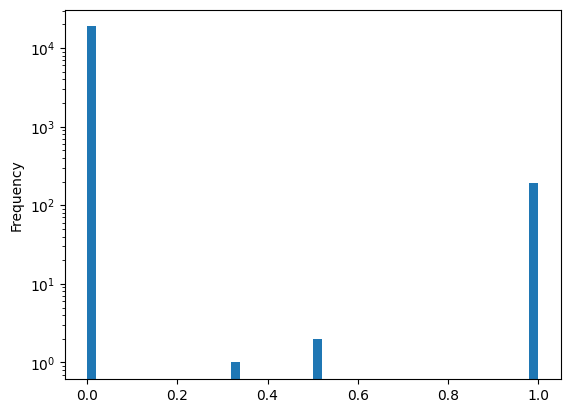

In [100]:
# FRACTION OF CLUSTER OCCUPIED BY POSITIVE GENES
uniref_df["fraction_positive"] = uniref_df.n_genes_positive / uniref_df.n_genes
uniref_df.sort_values(by="fraction_positive", inplace=True, ascending=False)

# hsit
uniref_df.fraction_positive.plot(kind="hist", logy=True, bins=50)
print(uniref_df.fraction_positive.value_counts().sort_index())


In [101]:
# HYPERGEMOETRIC TEST

# Filter genesets with enough genes
    # ATTENTION
    # CANNOT USE TOO SMALL DRAWING (n) --> test power comes from the changing probabilities over several draws, known as sampling without replacemen
uniref_df_big = uniref_df[uniref_df.n_genes >= 1].copy()

# Define background
total_genes = len(set().union(*uniref_df_big["gene"]))
total_positive = len(set().union(*uniref_df_big["genes_positive"]))
print(f"Unique total genes: {total_genes}")
print(f"Unique total positive genes: {total_positive}")

# Run enrichment test
results = uniref_df_big.apply(
    lambda row: pd.Series(
        dataf.per_cluster_hypergeom_test(
            row["n_genes"], 
            row["n_genes_positive"], 
            total_genes, 
            total_positive
        )
    ), 
    axis=1
)
results.columns = ["enrichment_prob", "enrichment_pvalue"]

# Combine results
df_uniref_enriched = pd.concat([uniref_df_big, results], axis=1)
df_uniref_enriched = df_uniref_enriched.sort_values("enrichment_pvalue")

# Multiple testing correction (FDR)
df_uniref_enriched["enrichment_pvalue_adj"] = multipletests(
    df_uniref_enriched["enrichment_pvalue"], 
    method="fdr_bh"
)[1]
df_uniref_enriched["significant"] = df_uniref_enriched["enrichment_pvalue_adj"] < 0.05

# Summary
print(f"\nSignificant enriched gene sets: {df_uniref_enriched['significant'].sum()} / {len(df_uniref_enriched)}")
display(
    df_uniref_enriched[
        ["UniRef50_Cluster", "n_genes", "n_genes_positive", 
         "enrichment_prob", "enrichment_pvalue", 
         "enrichment_pvalue_adj", "significant"]
    ].head(10)
)

# only enriched
df_uniref_significant = df_uniref_enriched[df_uniref_enriched['significant'] == True]

Unique total genes: 20184
Unique total positive genes: 198

Significant enriched gene sets: 1 / 18987


,UniRef50_Cluster,n_genes,n_genes_positive,enrichment_prob,enrichment_pvalue,enrichment_pvalue_adj,significant
3447,UniRef50_P0DP23,3,3,9.298873e-07,9.298873e-07,0.017656,True
11024,UniRef50_Q86XI2,1,1,9.809750e-03,9.809750e-03,0.965066,False
7696,UniRef50_Q15468,1,1,9.809750e-03,9.809750e-03,0.965066,False
13187,UniRef50_Q8WVK7,1,1,9.809750e-03,9.809750e-03,0.965066,False
9902,UniRef50_Q6UVJ0,1,1,9.809750e-03,9.809750e-03,0.965066,False
2391,UniRef50_O95067,1,1,9.809750e-03,9.809750e-03,0.965066,False
10917,UniRef50_Q86VI3,1,1,9.809750e-03,9.809750e-03,0.965066,False
5652,UniRef50_P53350,1,1,9.809750e-03,9.809750e-03,0.965066,False
9653,UniRef50_Q6P0N0,1,1,9.809750e-03,9.809750e-03,0.965066,False
18247,UniRef50_Q9UNS1,1,1,9.809750e-03,9.809750e-03,0.965066,False


# Create Dataset

## Positive class sampling

In [102]:
# Filter only positive clusters
uniref_df_pos = uniref_df[uniref_df.cluster_label == "positive"].copy()

# sample or take all postive proteins?
if not config["dataset_creation"]["sample_positive_genes"]:
    SAMPLE_N_POSITIVE = uniref_df_pos.n_genes_positive.max() # the number to sample is the max possbile
else:
    SAMPLE_N_POSITIVE = config["dataset_creation"]["number_positive_genes_to_sample_per_cluster"]

uniref_df_pos["proteins_sampled"], uniref_df_pos["genes_sampled"] = zip(
    *uniref_df_pos.apply(
            dataf.sample_sampled_from_single_row, 
            axis=1, 
            min_sample_n=SAMPLE_N_POSITIVE, 
            gene_col="genes_positive",  # ATTENTION_: sample from correct columns
            prot_col="proteins_positive", 
            probs_col="probs")
)
uniref_df_pos["n_proteins_sampled"] = uniref_df_pos.proteins_sampled.apply(len)

display(uniref_df_pos.head(2))
print(uniref_df_pos.shape)

,UniRef50_Cluster,protein,gene,n_proteins,n_genes,cluster_label,proteins_positive,genes_positive,n_genes_positive,logits,probs,putative_negative_proteins,putative_negative_genes,n_putative_negative_genes,fraction_positive,proteins_sampled,genes_sampled,n_proteins_sampled
11024,UniRef50_Q86XI2,[Q86XI2],[NCAPG2],1,1,positive,[Q86XI2],[NCAPG2],1,[17],[1.0],[],[],0,1.0,[Q86XI2],[NCAPG2],1
13187,UniRef50_Q8WVK7,[Q8WVK7],[SKA2],1,1,positive,[Q8WVK7],[SKA2],1,[20],[1.0],[],[],0,1.0,[Q8WVK7],[SKA2],1


(196, 18)


## Negative Sampling

ATTENTION: cannto have portisn from the same cluster split in class psotive and negative

In [103]:
# Filter only positive clusters
    # sample from clusters that do nto contain psotive (negative label of before)
uniref_df_neg = uniref_df[
    (uniref_df.n_putative_negative_genes > 0) & # some lcuster maybe haev only ambigus genes
    (uniref_df.cluster_label == "negative") # avoid proteins from proteins class are used as eagtive
    ].copy() 

uniref_df_neg["proteins_sampled"], uniref_df_neg["genes_sampled"] = zip(
    *uniref_df_neg.apply(
            dataf.sample_sampled_from_single_row, 
            axis=1, 
            min_sample_n=SAMPLE_N_POSITIVE, 
            gene_col="putative_negative_genes", 
            prot_col="putative_negative_proteins", 
            probs_col=None # uniform
            )
)
uniref_df_neg["n_proteins_sampled"] = uniref_df_neg.proteins_sampled.apply(len)

# ATTENTION: same clusters coudl have 0 proteins to sample from (all proteins are postive OR ambigous so nothing left to sample as negative)
uniref_df_neg = uniref_df_neg[uniref_df_neg.n_proteins_sampled > 0]

display(uniref_df_neg.head())
print(uniref_df_neg.shape)

,UniRef50_Cluster,protein,gene,n_proteins,n_genes,cluster_label,proteins_positive,genes_positive,n_genes_positive,logits,probs,putative_negative_proteins,putative_negative_genes,n_putative_negative_genes,fraction_positive,proteins_sampled,genes_sampled,n_proteins_sampled
8644,UniRef50_Q5JQC4,"[Q5JQC4, P0C2W7, A0A0U1RQG5]","[CT47A1, CT47B1, CT47C1]",3,3,negative,[],[],0,[],[],[Q5JQC4],[CT47A1],1,0.0,[Q5JQC4],[CT47A1],1
2480,UniRef50_O95377,"[O75712, Q9NTQ9, O95377]","[GJB3, GJB4, GJB5]",3,3,negative,[],[],0,[],[],[O75712],[GJB3],1,0.0,[O75712],[GJB3],1
6511,UniRef50_Q01524,[Q01524],[DEFA6],1,1,negative,[],[],0,[],[],[Q01524],[DEFA6],1,0.0,[Q01524],[DEFA6],1
6501,UniRef50_Q01415,[Q01415],[GALK2],1,1,negative,[],[],0,[],[],[Q01415],[GALK2],1,0.0,[Q01415],[GALK2],1
1518,UniRef50_O42043,"[O42043, O71037, P61565, P61566, P61570, P61567]","[ERVK-18, ERVK-19, ERVK-21, ERVK-24, ERVK-25, ...",6,6,negative,[],[],0,[],[],[O42043],[ERVK-18],1,0.0,[O42043],[ERVK-18],1


(2108, 18)


## Make dataset

- concat pos and neg
- expand to have

| Cluster | protein name | label | seq |

In [104]:
# add labels
uniref_df_pos["label_single_prot"] = 1
uniref_df_neg["label_single_prot"] = 0

# merge --> each entry is a cluster
dataset_df = pd.concat([uniref_df_pos, uniref_df_neg])
display(dataset_df.head())
display(dataset_df.shape)

,UniRef50_Cluster,protein,gene,n_proteins,n_genes,cluster_label,proteins_positive,genes_positive,n_genes_positive,logits,probs,putative_negative_proteins,putative_negative_genes,n_putative_negative_genes,fraction_positive,proteins_sampled,genes_sampled,n_proteins_sampled,label_single_prot
11024,UniRef50_Q86XI2,[Q86XI2],[NCAPG2],1,1,positive,[Q86XI2],[NCAPG2],1,[17],[1.0],[],[],0,1.0,[Q86XI2],[NCAPG2],1,1
13187,UniRef50_Q8WVK7,[Q8WVK7],[SKA2],1,1,positive,[Q8WVK7],[SKA2],1,[20],[1.0],[],[],0,1.0,[Q8WVK7],[SKA2],1,1
7696,UniRef50_Q15468,[Q15468],[STIL],1,1,positive,[Q15468],[STIL],1,[32],[1.0],[],[],0,1.0,[Q15468],[STIL],1,1
5652,UniRef50_P53350,[P53350],[PLK1],1,1,positive,[P53350],[PLK1],1,[76],[1.0],[],[],0,1.0,[P53350],[PLK1],1,1
9902,UniRef50_Q6UVJ0,[Q6UVJ0],[SASS6],1,1,positive,[Q6UVJ0],[SASS6],1,[28],[1.0],[],[],0,1.0,[Q6UVJ0],[SASS6],1,1


(2304, 19)

In [105]:
# Create long df

# smaller df
cols_to_keep = ['UniRef50_Cluster', 'proteins_sampled',
                'genes_sampled', 'label_single_prot']
dataset_df_small = dataset_df[cols_to_keep].copy()
display(dataset_df_small)

# Create a new DataFrame where each row corresponds to a (protein, gene) pair
rows = []
for _, row in dataset_df_small.iterrows():
    cluster = row["UniRef50_Cluster"]
    label = row["label_single_prot"]
    proteins = row["proteins_sampled"]
    genes = row["genes_sampled"]

    # zip ensures 1-to-1 pairing between proteins and genes
    for prot, gene in zip(proteins, genes):
        rows.append({
            "UniRef50_Cluster": cluster,
            "protein": prot,
            "gene": gene,
            "label": label
        })

df_long = pd.DataFrame(rows)

print("ATTENTION: the number of proteins sampled is less than the total ~20000 of Swissport, as we subsampled only N, so we may have lsot some proteins")
print(df_long.protein.nunique(), "/ ~20000")

# checj fro duplcates
print("\nDuplicated rows/proteins: ", df_long.shape[0] - df_long.protein.nunique())

df_long

,UniRef50_Cluster,proteins_sampled,genes_sampled,label_single_prot
11024,UniRef50_Q86XI2,[Q86XI2],[NCAPG2],1
13187,UniRef50_Q8WVK7,[Q8WVK7],[SKA2],1
7696,UniRef50_Q15468,[Q15468],[STIL],1
5652,UniRef50_P53350,[P53350],[PLK1],1
9902,UniRef50_Q6UVJ0,[Q6UVJ0],[SASS6],1
...,...,...,...,...
6582,UniRef50_Q02543,[Q02543],[RPL18A],0
6650,UniRef50_Q04671,[Q04671],[OCA2],0
6642,UniRef50_Q03989,[Q03989],[ARID5A],0
6221,UniRef50_P63272,[P63272],[SUPT4H1],0


ATTENTION: the number of proteins sampled is less than the total ~20000 of Swissport, as we subsampled only N, so we may have lsot some proteins
2306 / ~20000

Duplicated rows/proteins:  0


,UniRef50_Cluster,protein,gene,label
0,UniRef50_Q86XI2,Q86XI2,NCAPG2,1
1,UniRef50_Q8WVK7,Q8WVK7,SKA2,1
2,UniRef50_Q15468,Q15468,STIL,1
3,UniRef50_P53350,P53350,PLK1,1
4,UniRef50_Q6UVJ0,Q6UVJ0,SASS6,1
...,...,...,...,...
2301,UniRef50_Q02543,Q02543,RPL18A,0
2302,UniRef50_Q04671,Q04671,OCA2,0
2303,UniRef50_Q03989,Q03989,ARID5A,0
2304,UniRef50_P63272,P63272,SUPT4H1,0


## Assure 1:N ratio in postive:negative class
After previos sampling sampling you will have
- | pos prot | << | neg prot | → more thna 1:3 ration
- Need to subsampled negative class
- Subsample negative class
    - Subsample the remaining cluster to have a final ratio 1:3

In [106]:
# list of smpled positve proteins
positive_proteins_tmp = set(df_long[df_long.label == 1]["protein"].unique())

# list of prtein in MIXED cluster (wiht inside btoh postive and negative prteins)
    # ATTENTUON: check no ptortien in mixed clusters
proteins_in_mixed_clusters = df_long.groupby('UniRef50_Cluster').filter(lambda x: x['label'].nunique() > 1).sort_values(by="UniRef50_Cluster")
print("priteins in mixed clusters:", len(proteins_in_mixed_clusters))
proteins_in_mixed_clusters = set(proteins_in_mixed_clusters["protein"].unique())

# proteins to NOT remove
proteins_not_to_remove = proteins_in_mixed_clusters.union(positive_proteins_tmp)

# give col
df_long["can_be_removed"] = ~df_long["protein"].isin(proteins_not_to_remove)

df_long

priteins in mixed clusters: 0


,UniRef50_Cluster,protein,gene,label,can_be_removed
0,UniRef50_Q86XI2,Q86XI2,NCAPG2,1,False
1,UniRef50_Q8WVK7,Q8WVK7,SKA2,1,False
2,UniRef50_Q15468,Q15468,STIL,1,False
3,UniRef50_P53350,P53350,PLK1,1,False
4,UniRef50_Q6UVJ0,Q6UVJ0,SASS6,1,False
...,...,...,...,...,...
2301,UniRef50_Q02543,Q02543,RPL18A,0,True
2302,UniRef50_Q04671,Q04671,OCA2,0,True
2303,UniRef50_Q03989,Q03989,ARID5A,0,True
2304,UniRef50_P63272,P63272,SUPT4H1,0,True


In [107]:
# decide fraction to susample

# Number of positive proteins
n_positive = df_long[df_long["label"] == 1].shape[0]
# Number desidered negative
n_desired_negatives = n_positive * config["dataset_creation"]["mult_factor_negative_class"]
# Removable (negative) proteins
removable_negatives = df_long[(df_long["label"] == 0) & (df_long["can_be_removed"])]
# Determine fraction to subsample
frac_to_sample = n_desired_negatives / len(removable_negatives)
frac_to_sample = min(frac_to_sample, 1.0)  # cannot sample more than available

frac_to_sample

0.28178368121442127

In [108]:
# susample
removable = df_long[df_long["can_be_removed"]]
keep = df_long[~df_long["can_be_removed"]]

subsampled_removable = removable.sample(frac=frac_to_sample)

df_subsampled = pd.concat([keep, subsampled_removable]).reset_index(drop=True) # Combine back with the protected proteins

print(df_subsampled.label.value_counts())
df_subsampled

label
0    594
1    198
Name: count, dtype: int64


,UniRef50_Cluster,protein,gene,label,can_be_removed
0,UniRef50_Q86XI2,Q86XI2,NCAPG2,1,False
1,UniRef50_Q8WVK7,Q8WVK7,SKA2,1,False
2,UniRef50_Q15468,Q15468,STIL,1,False
3,UniRef50_P53350,P53350,PLK1,1,False
4,UniRef50_Q6UVJ0,Q6UVJ0,SASS6,1,False
...,...,...,...,...,...
787,UniRef50_Q7Z2W9,Q7Z2W9,MRPL21,0,True
788,UniRef50_A6H6Q4,A6NCJ1,TEKTIP1,0,True
789,UniRef50_P12277,P06732,CKM,0,True
790,UniRef50_Q9ULA0,Q9ULA0,DNPEP,0,True


## Give Sequence


In [109]:
### create df to join
join_df_tmp = proteome_uniprot[["Entry", "Sequence"]].copy().rename(columns={"Sequence": "sequence"})

# join
    # ATTNETION: we shoudl NOT lose any col
long_df_seq = pd.merge(how="inner", left=df_subsampled, right=join_df_tmp, left_on="protein", right_on="Entry")

# drp cols
long_df_seq.drop(columns=["Entry"], inplace=True)

long_df_seq

,UniRef50_Cluster,protein,gene,label,can_be_removed,sequence
0,UniRef50_Q86XI2,Q86XI2,NCAPG2,1,False,MEKRETFVQAVSKELVGEFLQFVQLDKEASDPFSLNELLDELSRKQ...
1,UniRef50_Q8WVK7,Q8WVK7,SKA2,1,False,MEAEVDKLELMFQKAESDLDYIQYRLEYEIKTNHPDSASEKNPVTL...
2,UniRef50_Q15468,Q15468,STIL,1,False,MEPIYPFARPQMNTRFPSSRMVPFHFPPSKCALWNPTPTGDFIYLH...
3,UniRef50_P53350,P53350,PLK1,1,False,MSAAVTAGKLARAPADPGKAGVPGVAAPGAPAAAPPAKEIPEVLVD...
4,UniRef50_Q6UVJ0,Q6UVJ0,SASS6,1,False,MSQVLFHQLVPLQVKCKDCEERRVSIRMSIELQSVSNPVHRKDLVI...
...,...,...,...,...,...,...
787,UniRef50_Q7Z2W9,Q7Z2W9,MRPL21,0,True,MAASSLTVTLGRLASACSHSILRPSGPGAASLWSASRRFNSQSTSY...
788,UniRef50_A6H6Q4,A6NCJ1,TEKTIP1,0,True,MQTLRQEAARPCIPSGTLEASFPAPLYSDDYLSLEGSRWPPAIRQA...
789,UniRef50_P12277,P06732,CKM,0,True,MPFGNTHNKFKLNYKPEEEYPDLSKHNNHMAKVLTLELYKKLRDKE...
790,UniRef50_Q9ULA0,Q9ULA0,DNPEP,0,True,MSGHSPTRGAMQVAMNGKARKEAVQTAAKELLKFVNRSPSPFHAVA...


## Stratify dataset

We can stratify based on many metrics:
1. labels
2. PREVALENT metric
3. **based on cluster**
    - Put proteins coming from same cluster in different sets or not

In [110]:
from sklearn.model_selection import train_test_split
import pandas as pd

# --- group-level stratified split ---

# pslit by cluster and then ive back set-label to each row

# One representative row per UniRef50_Cluster
cluster_df = long_df_seq.groupby('UniRef50_Cluster').first().reset_index()

# Stratified split by label, but at the cluster level
    # ists of unique cluster IDs.
train_clusters, temp_clusters = train_test_split(
    cluster_df['UniRef50_Cluster'],
    test_size=0.2,
    stratify=cluster_df['label'],
    random_state=42
)

# Split the temporary set equally into validation and test
temp_labels = cluster_df.loc[cluster_df['UniRef50_Cluster'].isin(temp_clusters), 'label']
val_clusters, test_clusters = train_test_split(
    temp_clusters,
    test_size=0.5,
    stratify=temp_labels,
    random_state=42
)

# --- assign back to the full dataframe ---
#Every row in long_df_seq inherits its set label based on its UniRef50_Cluster
long_df_seq['set'] = ''
long_df_seq.loc[long_df_seq['UniRef50_Cluster'].isin(train_clusters), 'set'] = 'train'
long_df_seq.loc[long_df_seq['UniRef50_Cluster'].isin(test_clusters), 'set'] = 'test'

# ATTENTION: ingore val
long_df_seq.loc[long_df_seq['UniRef50_Cluster'].isin(val_clusters), 'set'] = 'val'
long_df_seq.loc[long_df_seq['set'] == "val", 'set'] = 'test'
long_df_seq.loc[long_df_seq.loc[long_df_seq['set'] == 'test'].index[0], 'set'] = 'val' 

# Check split distribution
print(long_df_seq.groupby('set')['label'].value_counts().unstack(fill_value=0))
display(long_df_seq)


label    0    1
set            
test   119   38
train  475  159
val      0    1


,UniRef50_Cluster,protein,gene,label,can_be_removed,sequence,set
0,UniRef50_Q86XI2,Q86XI2,NCAPG2,1,False,MEKRETFVQAVSKELVGEFLQFVQLDKEASDPFSLNELLDELSRKQ...,train
1,UniRef50_Q8WVK7,Q8WVK7,SKA2,1,False,MEAEVDKLELMFQKAESDLDYIQYRLEYEIKTNHPDSASEKNPVTL...,train
2,UniRef50_Q15468,Q15468,STIL,1,False,MEPIYPFARPQMNTRFPSSRMVPFHFPPSKCALWNPTPTGDFIYLH...,train
3,UniRef50_P53350,P53350,PLK1,1,False,MSAAVTAGKLARAPADPGKAGVPGVAAPGAPAAAPPAKEIPEVLVD...,train
4,UniRef50_Q6UVJ0,Q6UVJ0,SASS6,1,False,MSQVLFHQLVPLQVKCKDCEERRVSIRMSIELQSVSNPVHRKDLVI...,train
...,...,...,...,...,...,...,...
787,UniRef50_Q7Z2W9,Q7Z2W9,MRPL21,0,True,MAASSLTVTLGRLASACSHSILRPSGPGAASLWSASRRFNSQSTSY...,test
788,UniRef50_A6H6Q4,A6NCJ1,TEKTIP1,0,True,MQTLRQEAARPCIPSGTLEASFPAPLYSDDYLSLEGSRWPPAIRQA...,train
789,UniRef50_P12277,P06732,CKM,0,True,MPFGNTHNKFKLNYKPEEEYPDLSKHNNHMAKVLTLELYKKLRDKE...,train
790,UniRef50_Q9ULA0,Q9ULA0,DNPEP,0,True,MSGHSPTRGAMQVAMNGKARKEAVQTAAKELLKFVNRSPSPFHAVA...,train


# Save

In [111]:
long_df_seq.to_csv(config["data_paths"]["final_dataset"], index=False)
config["data_paths"]["final_dataset"]
#long_df_seq.to_csv("/home/gdallagl/myworkdir/ESMSec/data/secreted/dataset_secreted.csv", index=False)

'/home/gdallagl/myworkdir/ESMSec/data/cell_cycle/datasets/cc_dataset_final.csv'